In [1]:
!pip install numpy networkx matplotlib xlsxwriter tqdm pandas

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


# BA 网络生成, 计算熵

In [1]:
import math
import numpy as np
import collections

def calculate_structural_entropy(subject_dict):
    """结构熵"""

    in_data = []
    out_data = []
    all_data = []
    
    for obj in subject_dict.values():
        
        if obj.get('i'):
            in_data.append(len(obj['i']))
            
        if obj.get('o'):
            out_data.append(len(obj['o']))
        
        cache = len(obj.get('i',[])) + len(obj.get('o',[]))
        if cache:
            all_data.append(cache)
            
    np_in = np.array(in_data)
    np_out = np.array(out_data)
    np_all = np.array(all_data)
    
    f = np_in/np_in.sum()
    entropy_in = (- f * np.log2(f)).sum()
    
    f = np_out/np_out.sum()
    entropy_out = (- f * np.log2(f)).sum()
    
    f = np_all/np_all.sum()
    entropy_ud = (- f * np.log2(f)).sum()
    
    # E min
    i_E_min = math.log2(4 * (len(np_in)-1))/2
    o_E_min = math.log2(4 * (len(np_out)-1))/2
    all_E_min = math.log2(4 * (len(np_all)-1))/2
    
    normalize_entropy_in = (entropy_in - i_E_min) / ( math.log2(len(np_in)) - i_E_min)
    normalize_entropy_out = (entropy_out - o_E_min) / ( math.log2(len(np_out)) - o_E_min)
    normalize_entropy_ud = (entropy_ud - all_E_min) / (math.log2(len(np_all)) - all_E_min)

    return (normalize_entropy_in,
            normalize_entropy_out,
            normalize_entropy_ud,
            entropy_in,
            entropy_out,
            entropy_ud,
            len(np_in),len(np_out),len(np_all))

def calculate_degree_distribution_entropy(subject_dict):
    '''度分布熵'''
    
    in_data = collections.defaultdict(int)
    out_data = collections.defaultdict(int)
    all_data = collections.defaultdict(int)
    
    for i,obj in subject_dict.items():
        
        in_data[len(obj['i'])] += 1
        out_data[len(obj['o'])] += 1
        
        cache = len(obj.get('i',[])) + len(obj.get('o',[]))
        if cache > 0 :
            all_data[cache] += 1
             
    np_in = np.array(list(in_data.values()))
    np_out = np.array(list(out_data.values()))
    np_all = np.array(list(all_data.values()))
    
    np_in = np_in / np_in.sum()
    np_out = np_out / np_out.sum()
    np_all = np_all / np_all.sum()
    
    entropy_in = np.nansum( np_in *  np.log2( 1/np_in ) )
    entropy_out = np.nansum( np_out *  np.log2( 1/np_out ) )
    entropy_ud = np.nansum( np_all *  np.log2( 1/np_all ) )
    
    return {
        'i':entropy_in,
        'o':entropy_out,
        'a':entropy_ud,
    }

def handle_entropy_value(edges):
    
    subject_dict = collections.defaultdict(lambda:{'i':[],'o':[]})
    for (node_in,node_out) in edges:
        subject_dict[node_in]['o'].append(node_out)
        subject_dict[node_out]['i'].append(node_in)
        
    dde_data = calculate_degree_distribution_entropy(subject_dict)
    se_data = calculate_structural_entropy(subject_dict)
    
    return (dde_data['i'],dde_data['o'], dde_data['a']),(se_data[0],se_data[1],se_data[2],se_data[3],se_data[4],se_data[5])

In [2]:

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
nx.__version__

'3.4.2'

In [3]:
# benchmark
# ((np.float64(1.75),
#   np.float64(0.5435644431995963),
#   np.float64(1.5487949406953985)),
#  (np.float64(0.24041077205417438),
#   np.float64(1.0),
#   np.float64(0.586523068142618),
#   np.float64(1.8423709931771084),
#   np.float64(2.807354922057604),
#   np.float64(2.753434386188785)))

edges = [(0, 1), (1, 2), (2, 1), (3, 4), (4, 5), (6, 4), (7, 4)]
handle_entropy_value(edges)

((np.float64(1.75),
  np.float64(0.5435644431995963),
  np.float64(1.5487949406953985)),
 (np.float64(0.24041077205417438),
  np.float64(1.0),
  np.float64(0.586523068142618),
  np.float64(1.8423709931771084),
  np.float64(2.807354922057604),
  np.float64(2.753434386188785)))

In [4]:
edges = [(1, 4), (2, 1), (2, 4), (3, 4), (5, 3), (5, 4)]
handle_entropy_value(edges)

((np.float64(1.5219280948873624),
  np.float64(1.5219280948873624),
  np.float64(0.7219280948873623)),
 (np.float64(-2.923299461574483),
  np.float64(0.6062805597688063),
  np.float64(0.7816315860094903),
  np.float64(1.2516291673878228),
  np.float64(1.9182958340544896),
  np.float64(2.2516291673878226)))

In [6]:
# 1	2,3	a
# 2	3,4,5	a
# 3	4,6	a

edges = [(1, 2),(1, 3), (2, 3)]
handle_entropy_value(edges)

1/3*np.log2(1/3) + 2/3*np.log2(2/3)

/tmp/ipykernel_4078054/2498505444.py:42: RuntimeWarning: divide by zero encountered in scalar divide
  normalize_entropy_in = (entropy_in - i_E_min) / ( math.log2(len(np_in)) - i_E_min)
/tmp/ipykernel_4078054/2498505444.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  normalize_entropy_out = (entropy_out - o_E_min) / ( math.log2(len(np_out)) - o_E_min)


np.float64(-0.9182958340544896)

In [6]:
import random
from networkx.utils import py_random_state


def _random_subset(seq, m, rng):
    """Return m unique elements from seq.

    This differs from random.sample which can return repeated
    elements if seq holds repeated elements.

    Note: rng is a random.Random or numpy.random.RandomState instance.
    """
    targets = set()
    while len(targets) < m:
        x = rng.choice(seq)
        targets.add(x)
    return targets

# @py_random_state(2)
def barabasi_albert_graph(n, m, seed=None, initial_graph=None):
    """Returns a random graph using Barabási–Albert preferential attachment

    A graph of $n$ nodes is grown by attaching new nodes each with $m$
    edges that are preferentially attached to existing nodes with high degree.

    Parameters
    ----------
    n : int
        Number of nodes
    m : int
        Number of edges to attach from a new node to existing nodes
    seed : integer, random_state, or None (default)
        Indicator of random number generation state.
        See :ref:`Randomness<randomness>`.
    initial_graph : Graph or None (default)
        Initial network for Barabási–Albert algorithm.
        It should be a connected graph for most use cases.
        A copy of `initial_graph` is used.
        If None, starts from a star graph on (m+1) nodes.

    Returns
    -------
    G : Graph

    Raises
    ------
    NetworkXError
        If `m` does not satisfy ``1 <= m < n``, or
        the initial graph number of nodes m0 does not satisfy ``m <= m0 <= n``.

    References
    ----------
    .. [1] A. L. Barabási and R. Albert "Emergence of scaling in
       random networks", Science 286, pp 509-512, 1999.
    """

    if m < 1 or m >= n:
        raise nx.NetworkXError(
            f"Barabási–Albert network must have m >= 1 and m < n, m = {m}, n = {n}"
        )

    if initial_graph is None:
        # Default initial graph : star graph on (m + 1) nodes
        G = nx.star_graph(m)
    else:
        if len(initial_graph) < m or len(initial_graph) > n:
            raise nx.NetworkXError(
                f"Barabási–Albert initial graph needs between m={m} and n={n} nodes"
            )
        G = initial_graph.copy()

    # List of existing nodes, with nodes repeated once for each adjacent edge
    repeated_nodes = [n for n, d in G.degree() for _ in range(d)]
    # Start adding the other n - m0 nodes.
    source = len(G)
    while source < n:
        # Now choose m unique nodes from the existing nodes
        # Pick uniformly from repeated_nodes (preferential attachment)
        current_m = m
        # current_m = math.ceil(m * math.log10(len(G)))
        targets = _random_subset(repeated_nodes,current_m, seed)

        # Add edges to m nodes from the source.
        G.add_edges_from(zip([source] * current_m, targets))

        # Add one node to the list for each new edge just created.
        repeated_nodes.extend(targets)
        
        # And the new node "source" has m edges to add to the list.
        repeated_nodes.extend([source] * current_m)

        source += 1
    return G

import random
g = barabasi_albert_graph(10,2,random,nx.generators.directed.scale_free_graph(2))
# nx.draw_shell(g,)
# len(g.edges())
print(handle_entropy_value(g.edges()))

((np.float64(2.1219280948873624), np.float64(0.8812908992306926), np.float64(2.1219280948873624)), (np.float64(0.7270704228886877), np.float64(0.9213061425651183), np.float64(0.8319560156931252), np.float64(2.4692407821722844), np.float64(3.263933429485634), np.float64(3.1980854601465896)))


In [7]:
from multiprocessing import Pool
import tqdm

def generate_ba_m2(x_list):
    entropy_combine_result_list = []
    G = nx.generators.directed.scale_free_graph(2)
    for x in tqdm.tqdm(x_list):
        G = barabasi_albert_graph(x,2,random,G)
        a = handle_entropy_value(G.edges())
        entropy_combine_result_list.append(a)
    return entropy_combine_result_list


def generate_ba_m5(x_list):
    entropy_combine_result_list = []
    G = nx.generators.directed.scale_free_graph(5)
    for x in tqdm.tqdm(x_list):
        G = barabasi_albert_graph(x,5,random,G)
        a = handle_entropy_value(G.edges())
        entropy_combine_result_list.append(a)
    return entropy_combine_result_list


def generate_ba_m8(x_list):
    entropy_combine_result_list = []
    G = nx.generators.directed.scale_free_graph(8)
    for x in tqdm.tqdm(x_list):
        G = barabasi_albert_graph(x,8,random,G)
        a = handle_entropy_value(G.edges())
        entropy_combine_result_list.append(a)
    return entropy_combine_result_list

In [42]:
# 采样次数
start_node_count=50
sampling_times = 66

sampling_point_list = np.array([int(start_node_count * 1.2**i) for i in range(sampling_times)])
print(len(sampling_point_list),sampling_point_list[-1])

66 7010532


In [9]:
Thread_Count = 5
pool_sampling_point_list = []
for _ in range(Thread_Count):
    pool_sampling_point_list.append(sampling_point_list.copy())

with Pool(45) as p:
    ret_ba_m8 = p.map(generate_ba_m8, pool_sampling_point_list)
with Pool(45) as p:
    ret_ba_m5 = p.map(generate_ba_m5, pool_sampling_point_list) 
with Pool(45) as p:
    ret_ba_m2 = p.map(generate_ba_m2, pool_sampling_point_list)

100%|██████████| 66/66 [28:20<00:00, 25.77s/it] 


In [10]:
def iterator_ret_data(data):
    """
    dimensition 20*100*2"""
    for row_20 in data:
        for row_100 in row_20:
            yield row_100

def hand_data_2(obj_arg):
    a_data = []
    b_data = []
    c_data = []
    for a,b,c,in obj_arg:
        a_data.append(a)
        b_data.append(b)
        c_data.append(c)
    a_data = np.array(a_data)
    b_data = np.array(b_data)
    c_data = np.array(c_data)
    return a_data,b_data,c_data
     
# 拟合函数
def draw_ba_generate_chart(ret_a,ret_b,ret_c,entropy_type, chart_type="structal"):
    x_data = np.tile(sampling_point_list, Thread_Count)
    
    fig, [(ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)] = plt.subplots(3,3,figsize=(24,18))
    a,b,c= hand_data_2(ret_a)
    ms = 2
    
    mark_size = 4
    ax1.scatter(x_data, a, s=mark_size, label='BA Entropy', color="green")
    ax2.scatter(x_data, b, s=mark_size, label='BA Entropy', color="green")
    ax3.scatter(x_data, c, s=mark_size, label='BA Entropy', color="green")

    ax1.set_title(f'm={ms} linksin {entropy_type} entropy').set_size(16)
    ax2.set_title(f'm={ms} linksout {entropy_type} entropy').set_size(16)
    ax3.set_title(f'm={ms} linksall {entropy_type} entropy').set_size(16)

    a,b,c= hand_data_2(ret_b)
    ms = 5

    ax4.scatter(x_data, a, s=mark_size, label='BA Entropy', color="green")
    ax5.scatter(x_data, b, s=mark_size, label='BA Entropy', color="green")
    ax6.scatter(x_data, c, s=mark_size, label='BA Entropy', color="green")

    ax4.set_title(f'm={ms} linksin {entropy_type} entropy').set_size(16)
    ax5.set_title(f'm={ms} linksout {entropy_type} entropy').set_size(16)
    ax6.set_title(f'm={ms} linksall {entropy_type} entropy').set_size(16)

    a,b,c= hand_data_2(ret_c)
    ms = 8

    ax7.scatter(x_data, a, s=mark_size, label='BA Entropy', color="green")
    ax8.scatter(x_data, b, s=mark_size, label='BA Entropy', color="green")
    ax9.scatter(x_data, c, s=mark_size, label='BA Entropy', color="green")

    ax7.set_title(f'm={ms} linksin {entropy_type} entropy').set_size(16)
    ax8.set_title(f'm={ms} linksout {entropy_type} entropy').set_size(16)
    ax9.set_title(f'm={ms} linksall {entropy_type} entropy').set_size(16)
    
    x_pred = np.linspace(min(sampling_point_list), max(sampling_point_list), 100)  # 生成x值
    y_pred_min = np.log2(4 * (x_pred-1))/2  # 根据预测公式计算y值
    y_pred_max = np.log2(x_pred)  # 根据预测公式计算y值

    for axx in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]:
        if chart_type == "structal":
            axx.plot(x_pred, y_pred_max, label='Entropy Max')
            axx.plot(x_pred, y_pred_min, label='Entropy Min')
        axx.legend()
    # plt.savefig("./b.svg")


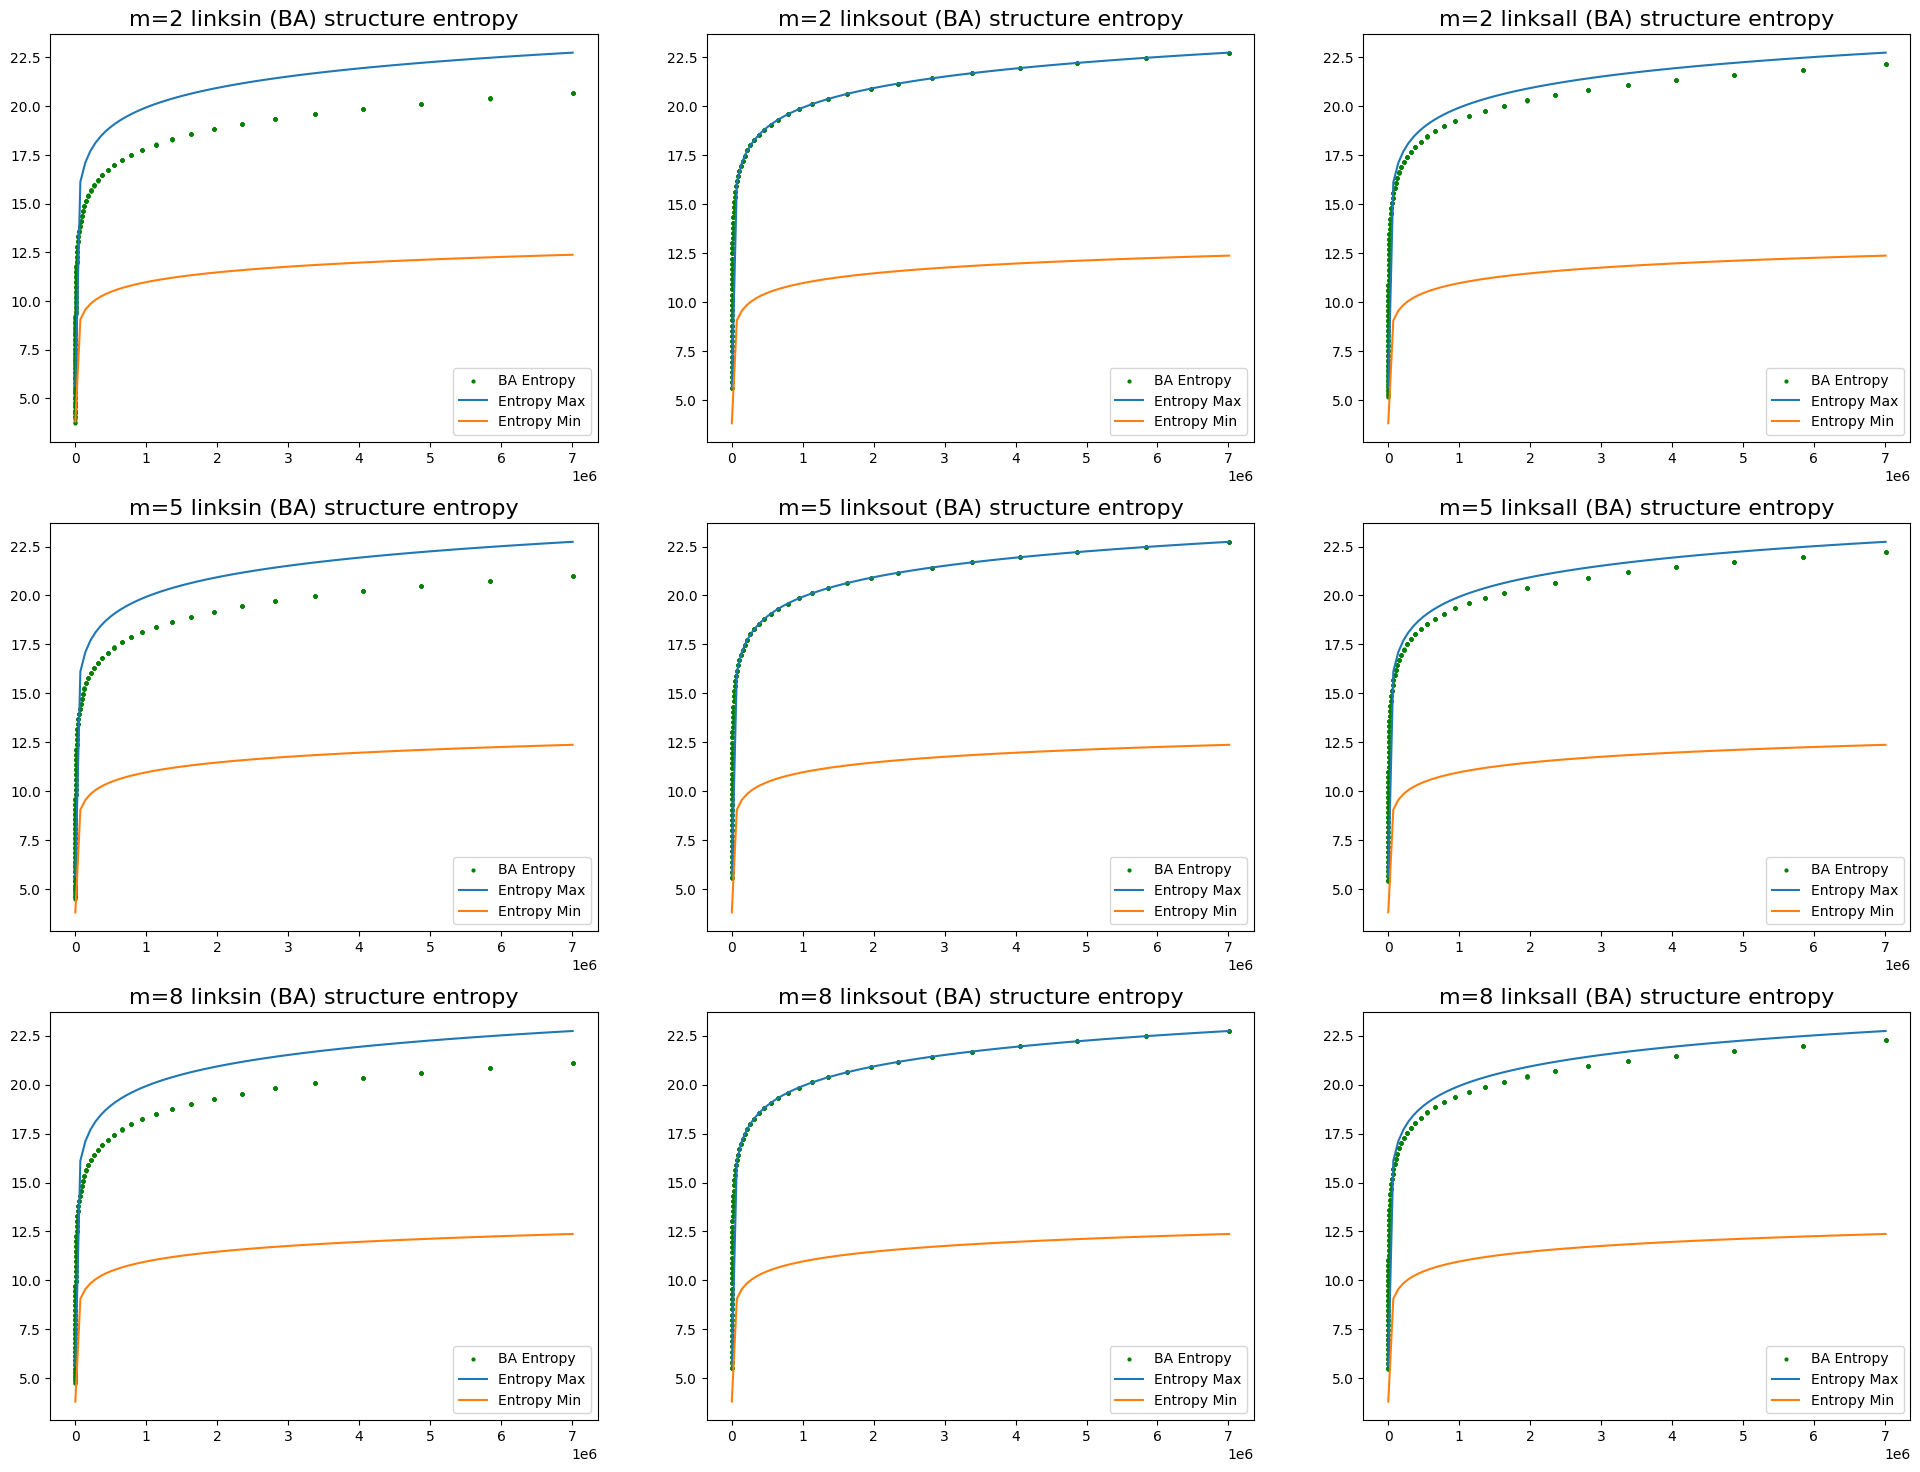

In [11]:
# 散点的数量是线程的数量x采样点的数量
a = [item[1][3:] for item in iterator_ret_data(ret_ba_m2)]
b = [item[1][3:] for item in iterator_ret_data(ret_ba_m5)]
c = [item[1][3:] for item in iterator_ret_data(ret_ba_m8)]
draw_ba_generate_chart(a,b,c,"(BA) structure")

In [43]:
import pandas as pd
# 打开一个 xlsx 文件
XLSX_WRITER = pd.ExcelWriter('generate_graph_stats.xlsx', engine="xlsxwriter")

In [13]:
# 散点的数量是线程的数量x采样点的数量
und_m2 = [item[1][5] for item in iterator_ret_data(ret_ba_m2)]
und_m5 = [item[1][5] for item in iterator_ret_data(ret_ba_m5)]
und_m8 = [item[1][5] for item in iterator_ret_data(ret_ba_m8)]

df = pd.DataFrame({
    'm2':und_m2,
    'm5':und_m5,
    'm8':und_m8,
}, index=np.tile(sampling_point_list, Thread_Count))

title = "BA Structural Entropy"
df.to_excel(XLSX_WRITER, sheet_name=title, index=True)

workbook = XLSX_WRITER.book
worksheet = XLSX_WRITER.sheets[title]

# 获取数据范围
num_rows, num_cols = df.shape  # 获取行数和列数
start_row = 1  # 数据开始的行（Excel 中 A2 行，0 为标题行）
end_row = start_row + num_rows - 1  # 数据结束行
category_col  = 0  # 月份列（第 1 列，索引从 0 开始）
sales_col = 1  # 销售列（第 2 列）

# 创建折线图
chart = workbook.add_chart({"type": "scatter"})
for col_idx, col_name in enumerate(df.columns, start=1):
    chart.add_series({
        "name":       col_name,  # 图表中的系列名称
        "categories": [title, start_row, category_col, end_row, category_col],  # 分类轴为索引
        "values":     [title, start_row, col_idx, end_row, col_idx],  # 值列
    })
chart.set_title({"name": "BA Undirected Graph: Structural Entropy"})
chart.set_x_axis({"name": "Node"})
chart.set_y_axis({"name": "Entropy",  'num_format': '#,##0'})
chart.set_size({'width': 600, 'height': 400})

# 插入图表
worksheet.insert_chart("B2", chart)

0

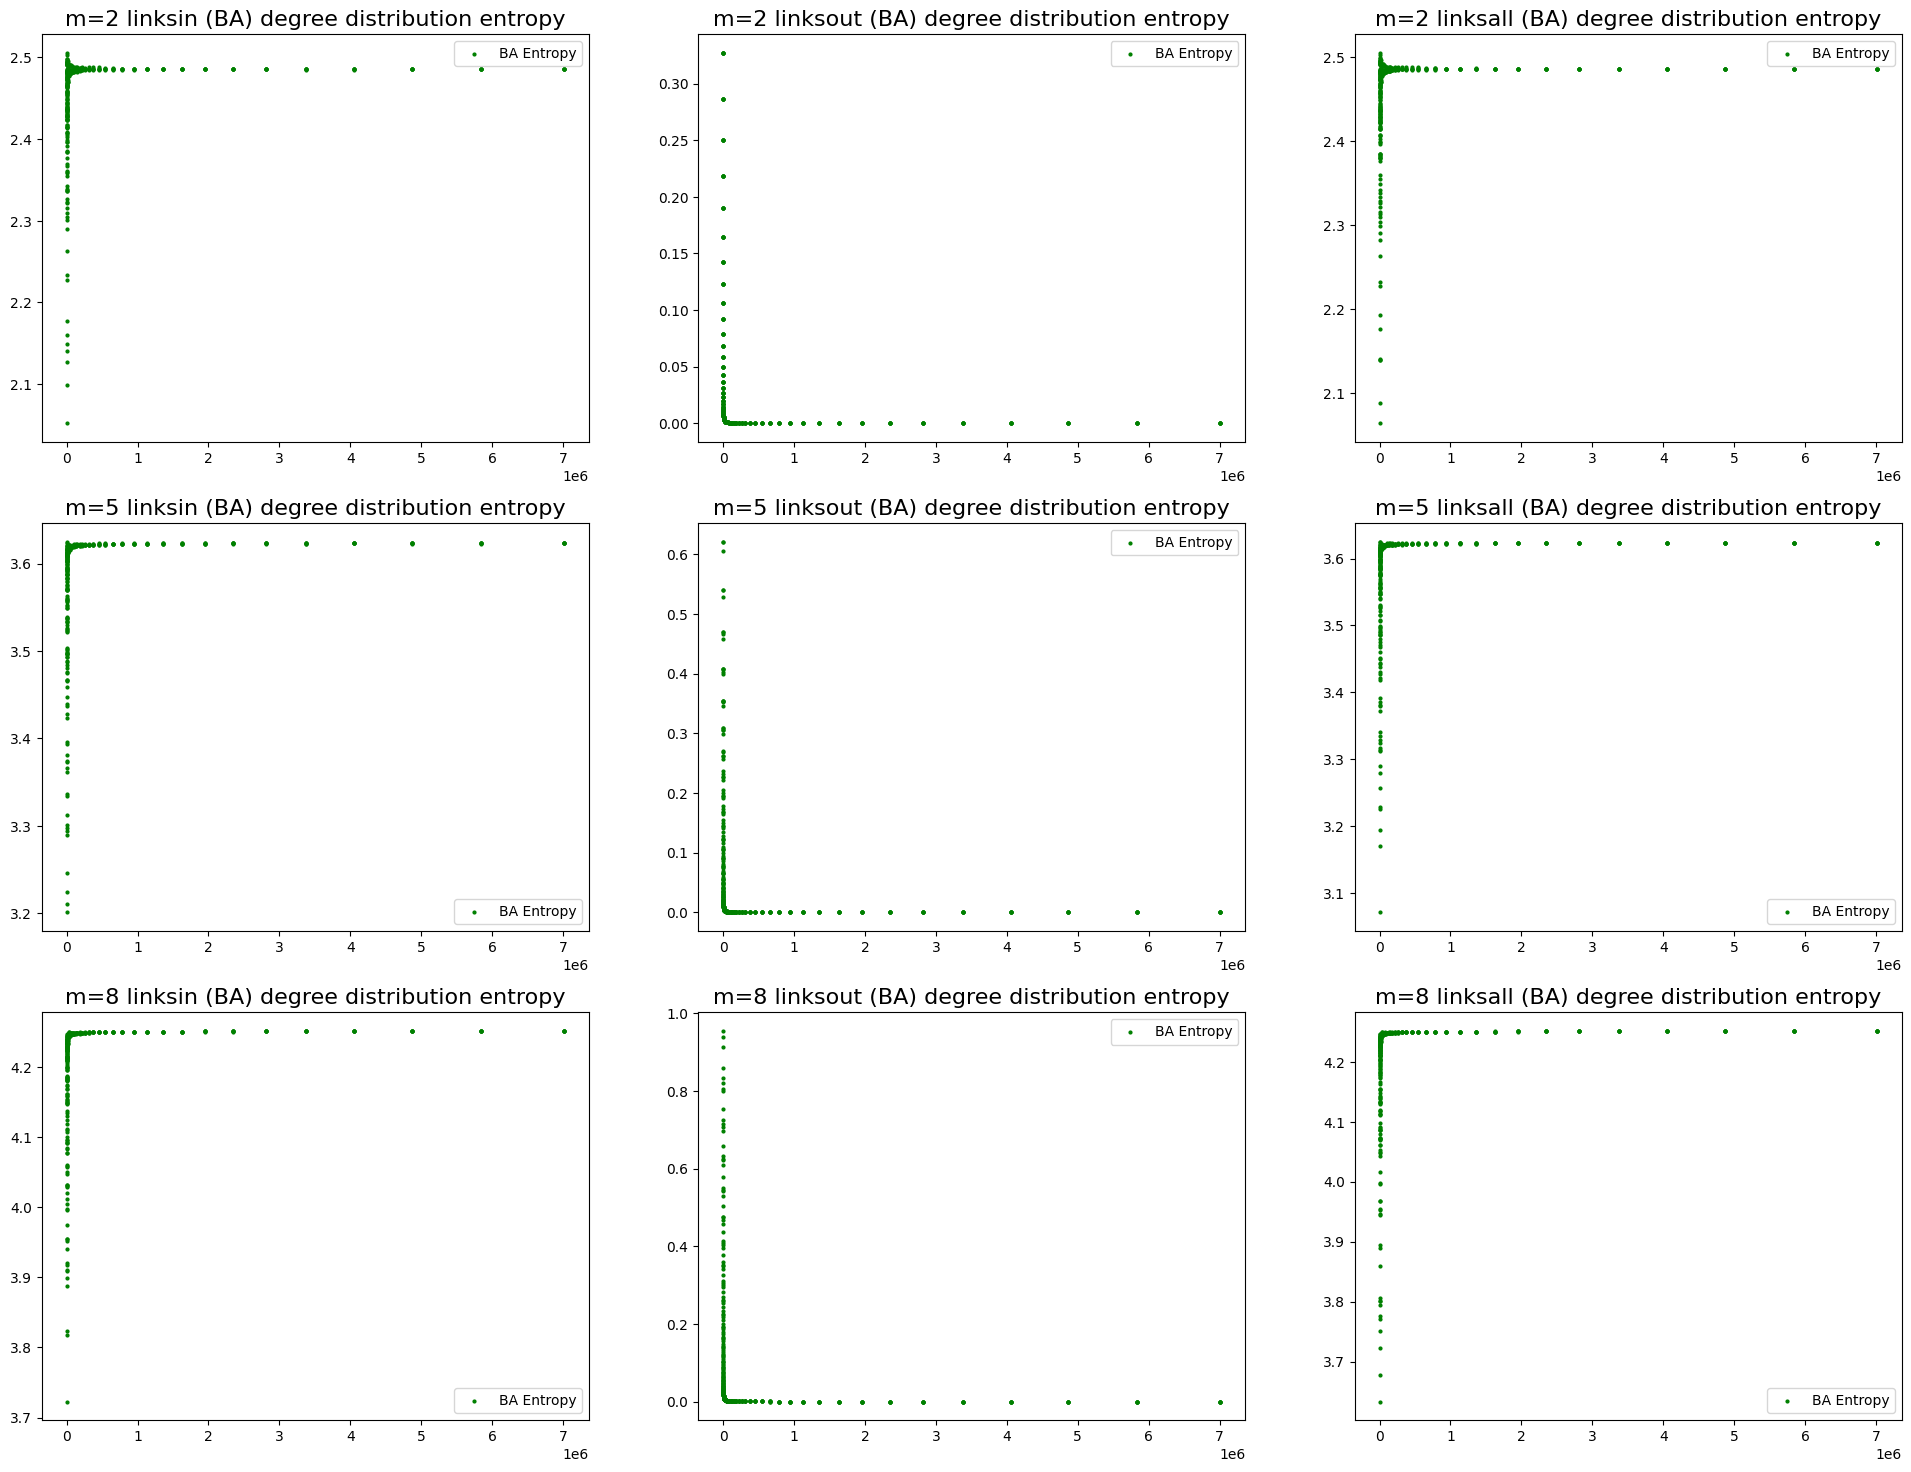

In [14]:
# 散点的数量是线程的数量x采样点的数量
a = [item[0] for item in iterator_ret_data(ret_ba_m2)]
b = [item[0] for item in iterator_ret_data(ret_ba_m5)]
c = [item[0] for item in iterator_ret_data(ret_ba_m8)]
draw_ba_generate_chart(a,b,c,"(BA) degree distribution", chart_type="degree")


In [ ]:
# 散点的数量是线程的数量x采样点的数量
und_m2 = [item[0][2] for item in iterator_ret_data(ret_ba_m2)]
und_m5 = [item[0][2] for item in iterator_ret_data(ret_ba_m5)]
und_m8 = [item[0][2] for item in iterator_ret_data(ret_ba_m8)]

df = pd.DataFrame({
    'm2':und_m2,
    'm5':und_m5,
    'm8':und_m8,
}, index=np.tile(sampling_point_list, Thread_Count))

title = "BA Degree Entropy"
df.to_excel(XLSX_WRITER, sheet_name=title, index=True)

workbook = XLSX_WRITER.book
worksheet = XLSX_WRITER.sheets[title]

# 获取数据范围
num_rows, num_cols = df.shape  # 获取行数和列数
start_row = 1  # 数据开始的行（Excel 中 A2 行，0 为标题行）
end_row = start_row + num_rows - 1  # 数据结束行
category_col  = 0  # 月份列（第 1 列，索引从 0 开始）
sales_col = 1  # 销售列（第 2 列）

# 创建折线图
chart = workbook.add_chart({"type": "scatter"})
for col_idx, col_name in enumerate(df.columns, start=1):
    chart.add_series({
        "name":       col_name,  # 图表中的系列名称
        "categories": [title, start_row, category_col, end_row, category_col],  # 分类轴为索引
        "values":     [title, start_row, col_idx, end_row, col_idx],  # 值列
    })
chart.set_title({"name": "BA Undirected Graph: Degree Distribution Entropy"})
chart.set_x_axis({"name": "Node"})
chart.set_y_axis({"name": "Entropy",  'num_format': '#,##0'})
chart.set_size({'width': 600, 'height': 400})

# 插入图表
worksheet.insert_chart("B2", chart)

In [16]:
# XLSX_WRITER.close()

# 随机图拟合
按照 20%, 40%,60% 的概率连接网络

In [17]:
from multiprocessing import Pool
import tqdm

def process_p20(x_list):
    ret_a = []
    G = nx.star_graph(2)
    for x in tqdm.tqdm(x_list):
        G = nx.fast_gnp_random_graph(x,0.2,create_using=G)
        a = handle_entropy_value(G.edges())
        ret_a.append(a)
    return ret_a

def process_p40(x_list):
    ret_a = []
    G = nx.star_graph(2)
    for x in tqdm.tqdm(x_list):
        G = nx.fast_gnp_random_graph(x,0.4,create_using=G)
        a = handle_entropy_value(G.edges())
        ret_a.append(a)
    return ret_a

def process_p60(x_list):
    ret_a = []
    G = nx.star_graph(2)
    for x in tqdm.tqdm(x_list):
        G = nx.fast_gnp_random_graph(x,0.6,create_using=G)
        a = handle_entropy_value(G.edges())
        ret_a.append(a)
    return ret_a

In [18]:
from multiprocessing import Pool

start_node_count=50
sampling_point_list = np.array([int(start_node_count * 1.2**i) for i in range(32)])
print(len(sampling_point_list),sampling_point_list[-1])

32 14242


In [19]:
Thread_Count = 20
pool_xdatas = []

pool_xdatas = np.tile(sampling_point_list,(Thread_Count,1))

with Pool(45) as p:
    ret_random_p60 = p.map(process_p60, pool_xdatas)
    
with Pool(45) as p:
    ret_random_p40 = p.map(process_p40, pool_xdatas)
    
with Pool(45) as p:
    ret_random_p20 = p.map(process_p20, pool_xdatas)


100%|██████████| 32/32 [03:25<00:00,  6.43s/it]

100%|██████████| 32/32 [03:30<00:00,  6.59s/it]


In [20]:
def draw_er_generate_chart(ret_a,ret_b,ret_c,entropy_type, chart_type="structal"):
    x_data = np.tile(sampling_point_list, Thread_Count)
    
    fig, [(ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)] = plt.subplots(3,3,figsize=(24,18))
    a,b,c= hand_data_2(ret_a)
    ms = 2
    
    mark_size = 4
    ax1.scatter(x_data, a, s=mark_size, label='ER Entropy', color="green")
    ax2.scatter(x_data, b, s=mark_size, label='ER Entropy', color="green")
    ax3.scatter(x_data, c, s=mark_size, label='ER Entropy', color="green")

    ax1.set_title(f'm={ms} linksin {entropy_type} entropy').set_size(16)
    ax2.set_title(f'm={ms} linksout {entropy_type} entropy').set_size(16)
    ax3.set_title(f'm={ms} linksall {entropy_type} entropy').set_size(16)

    a,b,c= hand_data_2(ret_b)
    ms = 5

    ax4.scatter(x_data, a, s=mark_size, label='ER Entropy', color="green")
    ax5.scatter(x_data, b, s=mark_size, label='ER Entropy', color="green")
    ax6.scatter(x_data, c, s=mark_size, label='ER Entropy', color="green")

    ax4.set_title(f'm={ms} linksin {entropy_type} entropy').set_size(16)
    ax5.set_title(f'm={ms} linksout {entropy_type} entropy').set_size(16)
    ax6.set_title(f'm={ms} linksall {entropy_type} entropy').set_size(16)

    a,b,c= hand_data_2(ret_c)
    ms = 8

    ax7.scatter(x_data, a, s=mark_size, label='ER Entropy', color="green")
    ax8.scatter(x_data, b, s=mark_size, label='ER Entropy', color="green")
    ax9.scatter(x_data, c, s=mark_size, label='ER Entropy', color="green")

    ax7.set_title(f'm={ms} linksin {entropy_type} entropy').set_size(16)
    ax8.set_title(f'm={ms} linksout {entropy_type} entropy').set_size(16)
    ax9.set_title(f'm={ms} linksall {entropy_type} entropy').set_size(16)
    
    x_pred = np.linspace(min(sampling_point_list), max(sampling_point_list), 100)  # 生成x值
    y_pred_min = np.log2(4 * (x_pred-1))/2  # 根据预测公式计算y值
    y_pred_max = np.log2(x_pred)  # 根据预测公式计算y值

    for axx in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]:
        if chart_type == "structal":
            axx.plot(x_pred, y_pred_max, label='Entropy Max')
            axx.plot(x_pred, y_pred_min, label='Entropy Min')
        axx.legend()
    # plt.savefig("./b.svg")

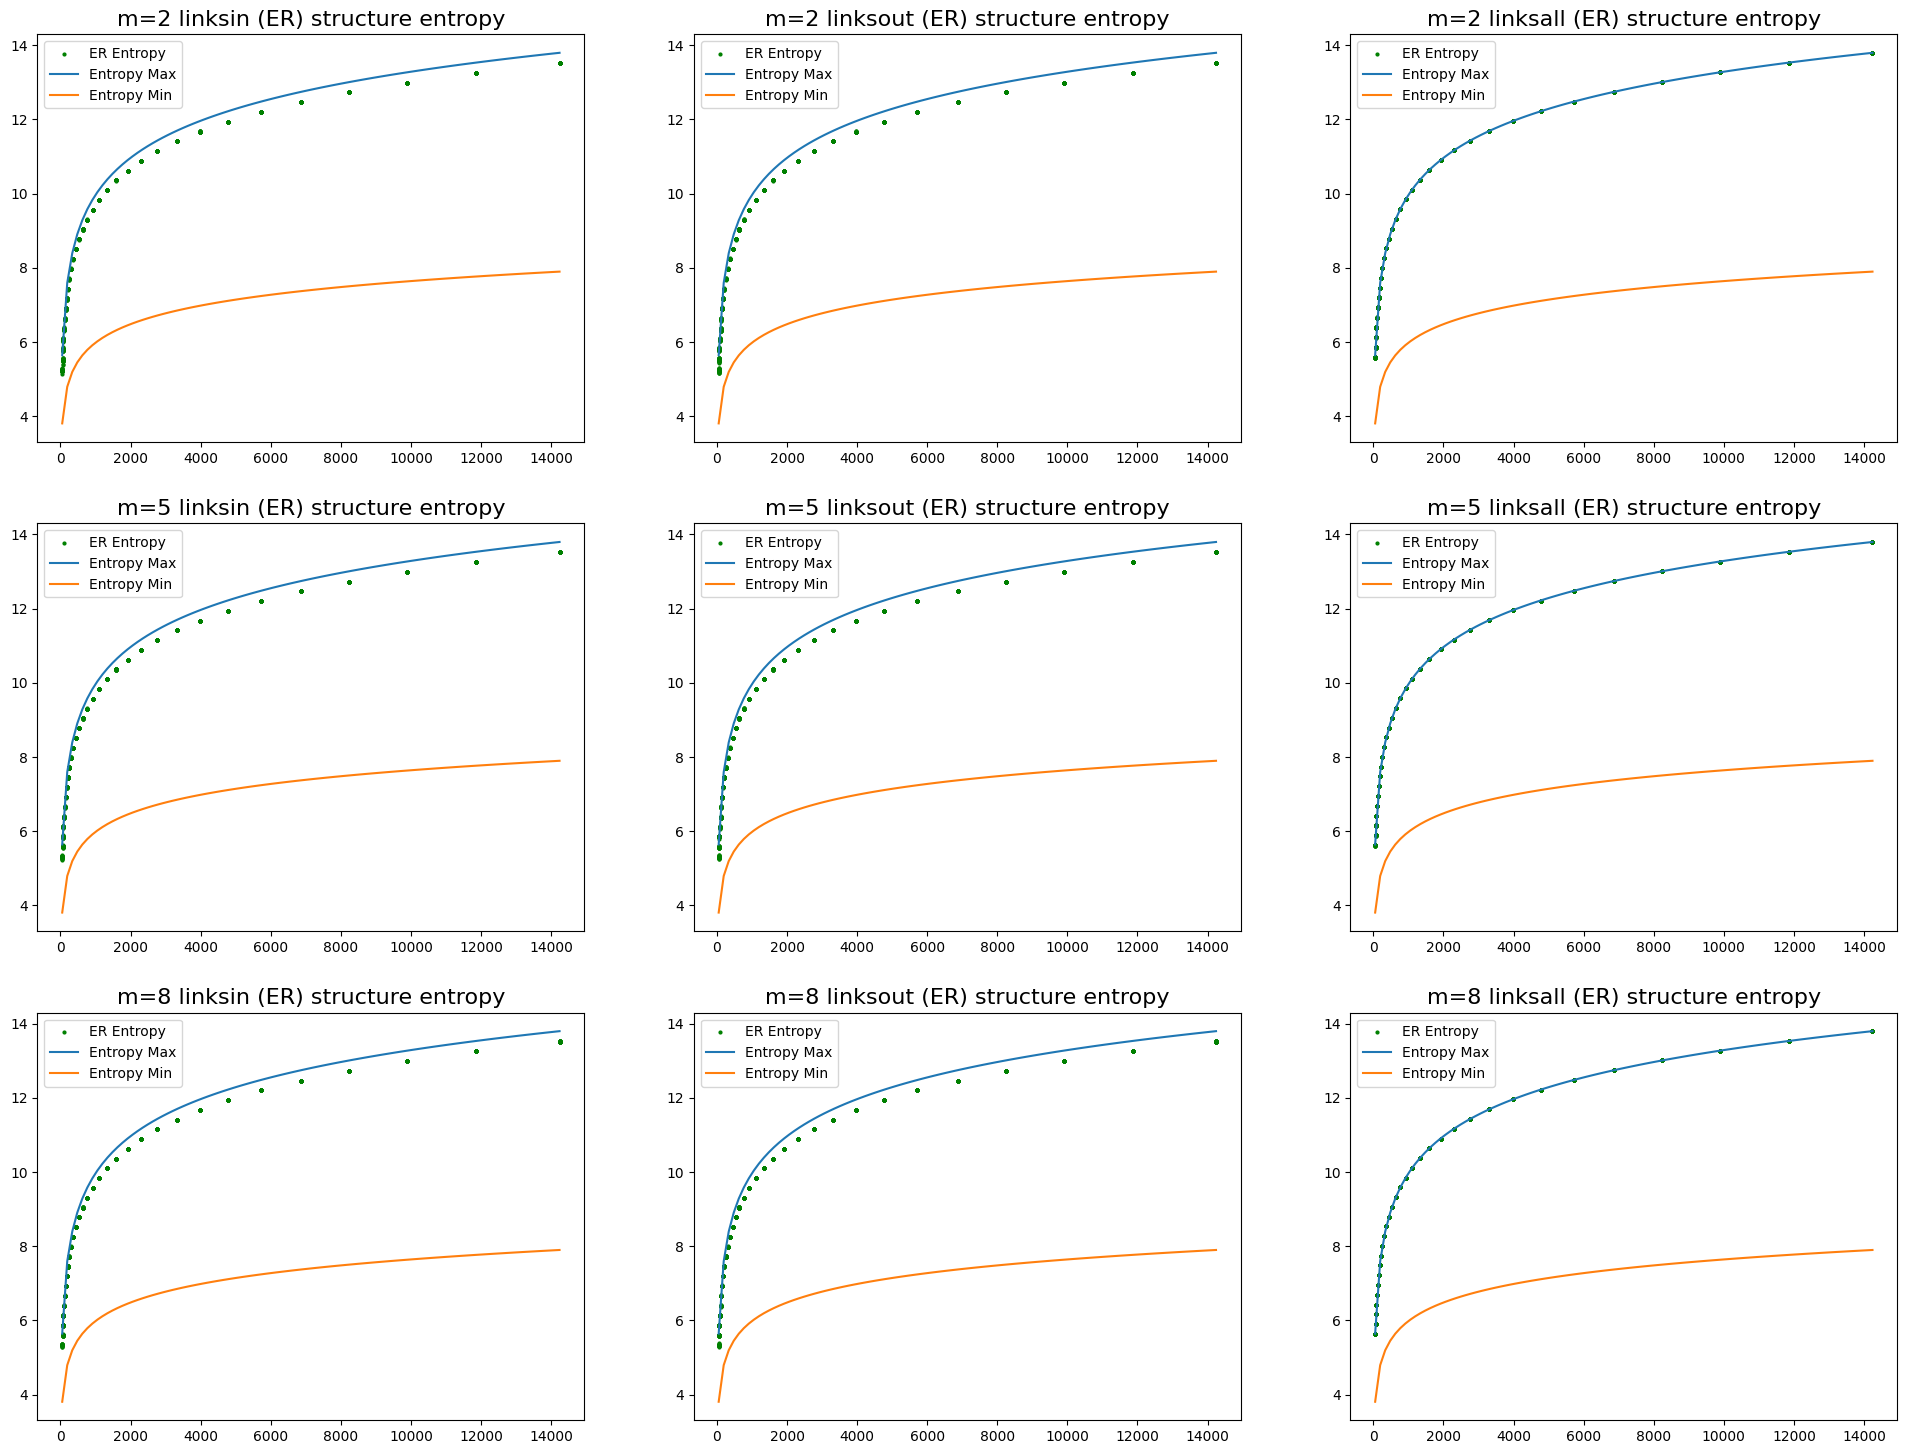

In [21]:
# 散点的数量是线程的数量x采样点的数量
a = [item[1][3:] for item in iterator_ret_data(ret_random_p20)]
b = [item[1][3:] for item in iterator_ret_data(ret_random_p40)]
c = [item[1][3:] for item in iterator_ret_data(ret_random_p60)]
draw_er_generate_chart(a,b,c,"(ER) structure")

In [22]:
import pandas as pd
# 打开一个 xlsx 文件
# XLSX_WRITER = pd.ExcelWriter('generate_er_graph_stats.xlsx', engine="xlsxwriter")

In [23]:
# 散点的数量是线程的数量x采样点的数量
und_p20 = [item[1][5] for item in iterator_ret_data(ret_random_p20)]
und_p40 = [item[1][5] for item in iterator_ret_data(ret_random_p40)]
und_p60 = [item[1][5] for item in iterator_ret_data(ret_random_p60)]

df = pd.DataFrame({
    'p20':und_p20,
    'p40':und_p40,
    'p60':und_p60,
}, index=np.tile(sampling_point_list, Thread_Count))

title = "ER Structural Entropy"
df.to_excel(XLSX_WRITER, sheet_name=title, index=True)

workbook = XLSX_WRITER.book
worksheet = XLSX_WRITER.sheets[title]

# 获取数据范围
num_rows, num_cols = df.shape  # 获取行数和列数
start_row = 1  # 数据开始的行（Excel 中 A2 行，0 为标题行）
end_row = start_row + num_rows - 1  # 数据结束行
category_col  = 0  # 月份列（第 1 列，索引从 0 开始）
sales_col = 1  # 销售列（第 2 列）

# 创建折线图
chart = workbook.add_chart({"type": "scatter"})
for col_idx, col_name in enumerate(df.columns, start=1):
    chart.add_series({
        "name":       col_name,  # 图表中的系列名称
        "categories": [title, start_row, category_col, end_row, category_col],  # 分类轴为索引
        "values":     [title, start_row, col_idx, end_row, col_idx],  # 值列
    })
chart.set_title({"name": "ER Undirected Graph: Structural Entropy"})
chart.set_x_axis({"name": "Node"})
chart.set_y_axis({"name": "Entropy",  'num_format': '#,##0'})
chart.set_size({'width': 600, 'height': 400})

# 插入图表
worksheet.insert_chart("B2", chart)

0

In [24]:
# 散点的数量是线程的数量x采样点的数量
und_p20 = [item[0][2] for item in iterator_ret_data(ret_random_p20)]
und_p40 = [item[0][2] for item in iterator_ret_data(ret_random_p40)]
und_p60 = [item[0][2] for item in iterator_ret_data(ret_random_p60)]

df = pd.DataFrame({
    'p20':und_p20,
    'p40':und_p40,
    'p60':und_p60,
}, index=np.tile(sampling_point_list, Thread_Count))

title = "ER Degree Entropy"
df.to_excel(XLSX_WRITER, sheet_name=title, index=True)

workbook = XLSX_WRITER.book
worksheet = XLSX_WRITER.sheets[title]

# 获取数据范围
num_rows, num_cols = df.shape  # 获取行数和列数
start_row = 1  # 数据开始的行（Excel 中 A2 行，0 为标题行）
end_row = start_row + num_rows - 1  # 数据结束行
category_col  = 0  # 月份列（第 1 列，索引从 0 开始）
sales_col = 1  # 销售列（第 2 列）

# 创建折线图
chart = workbook.add_chart({"type": "scatter"})
for col_idx, col_name in enumerate(df.columns, start=1):
    chart.add_series({
        "name":       col_name,  # 图表中的系列名称
        "categories": [title, start_row, category_col, end_row, category_col],  # 分类轴为索引
        "values":     [title, start_row, col_idx, end_row, col_idx],  # 值列
    })
chart.set_title({"name": "ER Undirected Graph: Degree Distribution Entropy"})
chart.set_x_axis({"name": "Node"})
chart.set_y_axis({"name": "Entropy",  'num_format': '#,##0'})
chart.set_size({'width': 600, 'height': 400})

# 插入图表
worksheet.insert_chart("B2", chart)

0

In [25]:
# XLSX_WRITER.close()

# ER 概率百分比图

In [26]:
sampling_point_list = np.arange(0.01, 1+0.01, 0.01)

graph_size = 10_000
def process(p):
    G = nx.fast_gnp_random_graph(graph_size,p)
    # G = nx.fast_gnp_random_graph(100,p)
    a = handle_entropy_value(G.edges())
    return a

# 采样次数

Thread_Count = 20
pool_xdatas = []

pool_xdatas = np.tile(sampling_point_list,Thread_Count)

with Pool(45) as p:
    ret_random_percent = p.map(process, pool_xdatas)

In [27]:
degree_entropy_list = [item[0][2] for item in ret_random_percent]
structural_entropy_list = [item[1][5] for item in ret_random_percent]

In [28]:
# 拟合函数
def draw_trend(x_data,y_data, chart_type="structal"):
    
    fig, ax = plt.subplots()
    ax.scatter(x_data, y_data, s=2, label=f'{chart_type} Entropy', color="green")
    ax.set_title(f"n={graph_size} random_graph").set_size(16)
    ax.set_xlabel("p")
    ax.legend()


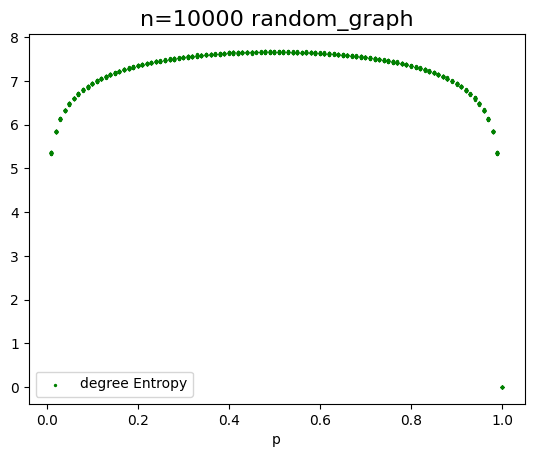

In [29]:
draw_trend(pool_xdatas, degree_entropy_list,"degree")

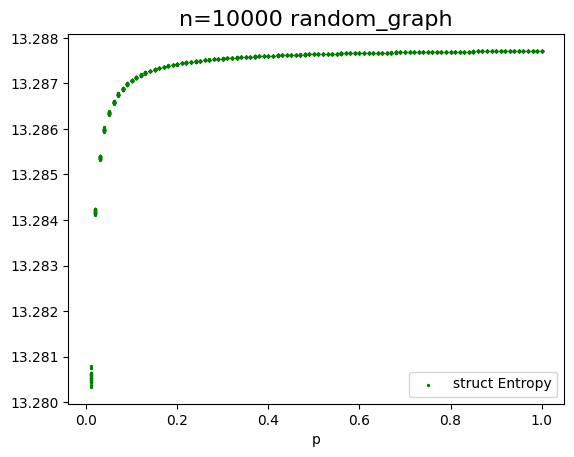

In [30]:
draw_trend(pool_xdatas, structural_entropy_list, "struct")

In [31]:

# XLSX_WRITER = pd.ExcelWriter('generate_er_graph_stats.xlsx', engine="xlsxwriter")

In [32]:
# 散点的数量是线程的数量x采样点的数量
degree_entropy_list = [item[0][2] for item in ret_random_percent]
structural_entropy_list = [item[1][5] for item in ret_random_percent]

df = pd.DataFrame({
    'degree':degree_entropy_list,
    'structural':structural_entropy_list,
}, index=np.tile(sampling_point_list, Thread_Count))

title = "ER probability"
df.to_excel(XLSX_WRITER, sheet_name=title, index=True)

workbook = XLSX_WRITER.book
worksheet = XLSX_WRITER.sheets[title]

# 获取数据范围
num_rows, num_cols = df.shape  # 获取行数和列数
start_row = 1  # 数据开始的行（Excel 中 A2 行，0 为标题行）
end_row = start_row + num_rows - 1  # 数据结束行
category_col  = 0  # 月份列（第 1 列，索引从 0 开始）
sales_col = 1  # 销售列（第 2 列）

# 创建折线图
chart = workbook.add_chart({"type": "scatter"})
for col_idx, col_name in enumerate(df.columns, start=1):
    chart.add_series({
        "name":       col_name,  # 图表中的系列名称
        "categories": [title, start_row, category_col, end_row, category_col],  # 分类轴为索引
        "values":     [title, start_row, col_idx, end_row, col_idx],  # 值列
    })
chart.set_title({"name": f"Undirected Graph {graph_size}: Entropy"})
chart.set_x_axis({"name": "Probility"})
chart.set_y_axis({"name": "Entropy",  'num_format': '#,##0'})
chart.set_size({'width': 600, 'height': 400})

# 插入图表
worksheet.insert_chart("B2", chart)

0

In [33]:
# XLSX_WRITER.close()

# 小世界网络

In [60]:
def draw_ws_generate_chart(ret_a,ret_b,ret_c,entropy_type, chart_type="structal"):
    x_data = np.tile(sampling_point_list, Thread_Count)
    
    fig, [(ax1,ax2,ax3),(ax4,ax5,ax6),(ax7,ax8,ax9)] = plt.subplots(3,3,figsize=(24,18))
    a,b,c= hand_data_2(ret_a)
    ms = 2
    
    mark_size = 4
    ax1.scatter(x_data, a, s=mark_size, label='ER Entropy', color="green")
    ax2.scatter(x_data, b, s=mark_size, label='ER Entropy', color="green")
    ax3.scatter(x_data, c, s=mark_size, label='ER Entropy', color="green")

    ax1.set_title(f'm={ms} linksin {entropy_type} entropy').set_size(16)
    ax2.set_title(f'm={ms} linksout {entropy_type} entropy').set_size(16)
    ax3.set_title(f'm={ms} linksall {entropy_type} entropy').set_size(16)

    a,b,c= hand_data_2(ret_b)
    ms = 5

    ax4.scatter(x_data, a, s=mark_size, label='ER Entropy', color="green")
    ax5.scatter(x_data, b, s=mark_size, label='ER Entropy', color="green")
    ax6.scatter(x_data, c, s=mark_size, label='ER Entropy', color="green")

    ax4.set_title(f'm={ms} linksin {entropy_type} entropy').set_size(16)
    ax5.set_title(f'm={ms} linksout {entropy_type} entropy').set_size(16)
    ax6.set_title(f'm={ms} linksall {entropy_type} entropy').set_size(16)

    a,b,c= hand_data_2(ret_c)
    ms = 8

    ax7.scatter(x_data, a, s=mark_size, label='ER Entropy', color="green")
    ax8.scatter(x_data, b, s=mark_size, label='ER Entropy', color="green")
    ax9.scatter(x_data, c, s=mark_size, label='ER Entropy', color="green")

    ax7.set_title(f'm={ms} linksin {entropy_type} entropy').set_size(16)
    ax8.set_title(f'm={ms} linksout {entropy_type} entropy').set_size(16)
    ax9.set_title(f'm={ms} linksall {entropy_type} entropy').set_size(16)
    
    x_pred = np.linspace(min(sampling_point_list), max(sampling_point_list), 100)  # 生成x值
    y_pred_min = np.log2(4 * (x_pred-1))/2  # 根据预测公式计算y值
    y_pred_max = np.log2(x_pred)  # 根据预测公式计算y值

    for axx in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9]:
        if chart_type == "structal":
            axx.plot(x_pred, y_pred_max, label='Entropy Max')
            axx.plot(x_pred, y_pred_min, label='Entropy Min')
        axx.legend()
    # plt.savefig("./b.svg")

In [168]:
from multiprocessing import Pool

start_node_count=50
sampling_point_list = np.array([int(start_node_count * 1.2**i) for i in range(70)])
# sampling_point_list = np.array([int(start_node_count * 1.2*(i+1)) for i in range(100)])
print(len(sampling_point_list),sampling_point_list[-1])

70 14537039


In [169]:
def process_p10(x_list):
    ret_a = []
    G = None
    for x in tqdm.tqdm(x_list):
        if G:
            G = nx.watts_strogatz_graph(x,2,0.1, create_using=G)
        else:
            G = nx.watts_strogatz_graph(x,2,0.1)
        a = handle_entropy_value(G.edges())
        ret_a.append(a)
    return ret_a

def process_p20(x_list):
    ret_a = []
    G = None
    for x in tqdm.tqdm(x_list):
        if G:
            G = nx.watts_strogatz_graph(x,2,0.2, create_using=G)
        else:
            G = nx.watts_strogatz_graph(x,2,0.2)
        a = handle_entropy_value(G.edges())
        ret_a.append(a)
    return ret_a

def process_p30(x_list):
    ret_a = []
    G = None
    for x in tqdm.tqdm(x_list):
        if G:
            G = nx.watts_strogatz_graph(x,2,0.3, create_using=G)
        else:
            G = nx.watts_strogatz_graph(x,2,0.3)
        a = handle_entropy_value(G.edges())
        ret_a.append(a)
    return ret_a

Thread_Count=5
pool_xdatas = []
pool_xdatas = np.tile(sampling_point_list,(Thread_Count,1))

with Pool(45) as p:
    ret_wsg_p10 = p.map(process_p10, pool_xdatas)
with Pool(45) as p:
    ret_wsg_p20 = p.map(process_p20, pool_xdatas)
with Pool(45) as p:
    ret_wsg_p30 = p.map(process_p30, pool_xdatas)


100%|██████████| 70/70 [18:51<00:00, 16.16s/it] 


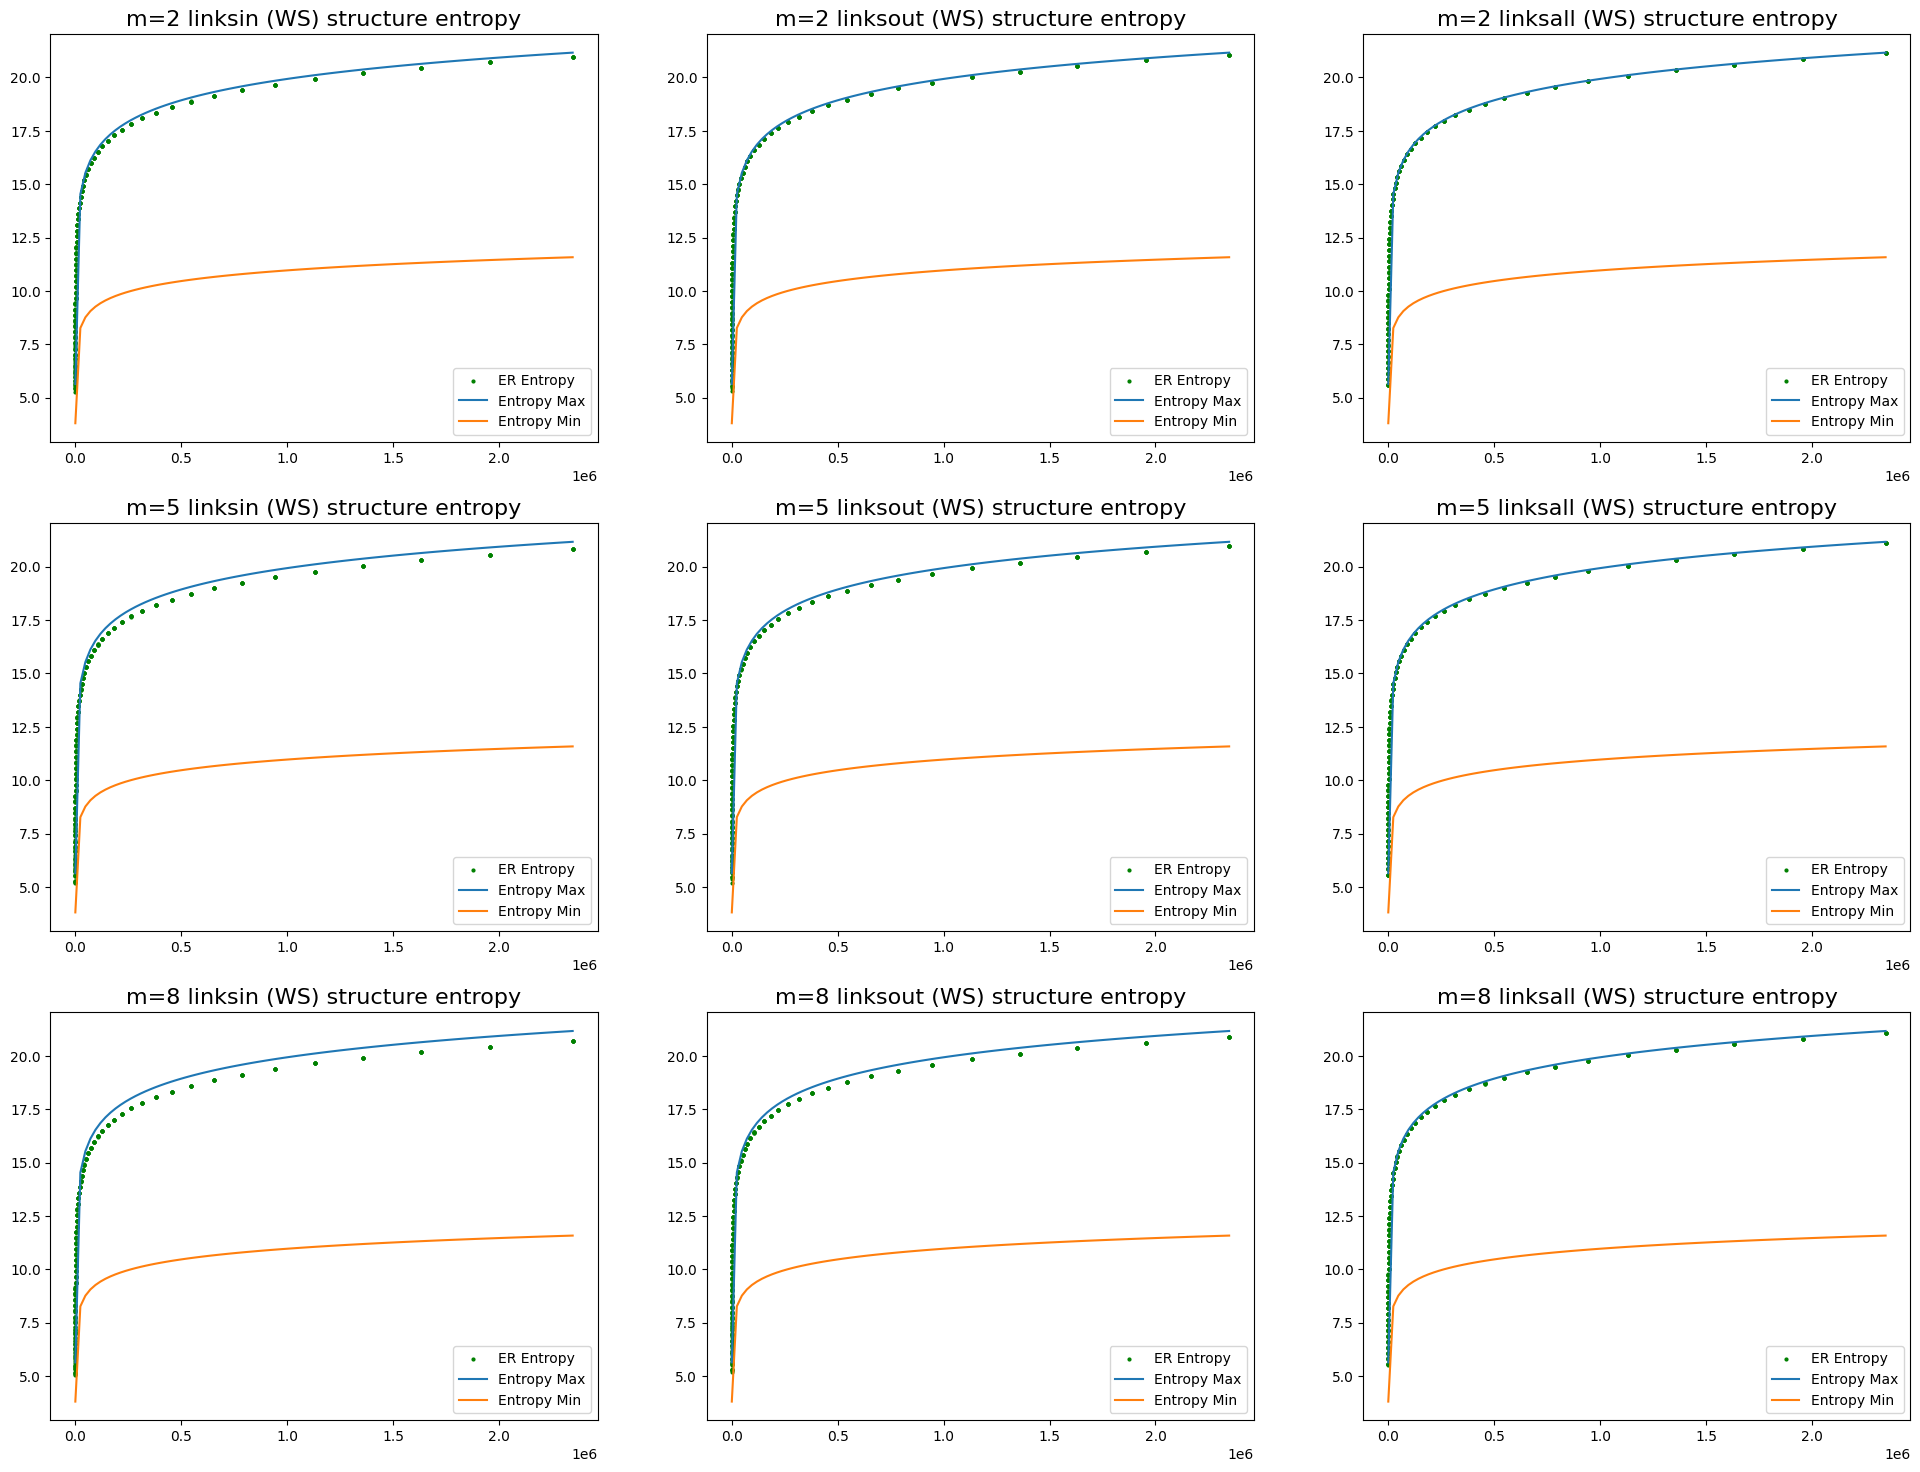

In [161]:

a = [item[1][3:] for item in iterator_ret_data(ret_wsg_p10)]
b = [item[1][3:] for item in iterator_ret_data(ret_wsg_p20)]
c = [item[1][3:] for item in iterator_ret_data(ret_wsg_p30)]

draw_ws_generate_chart(a,b,c,"(WS) structure")

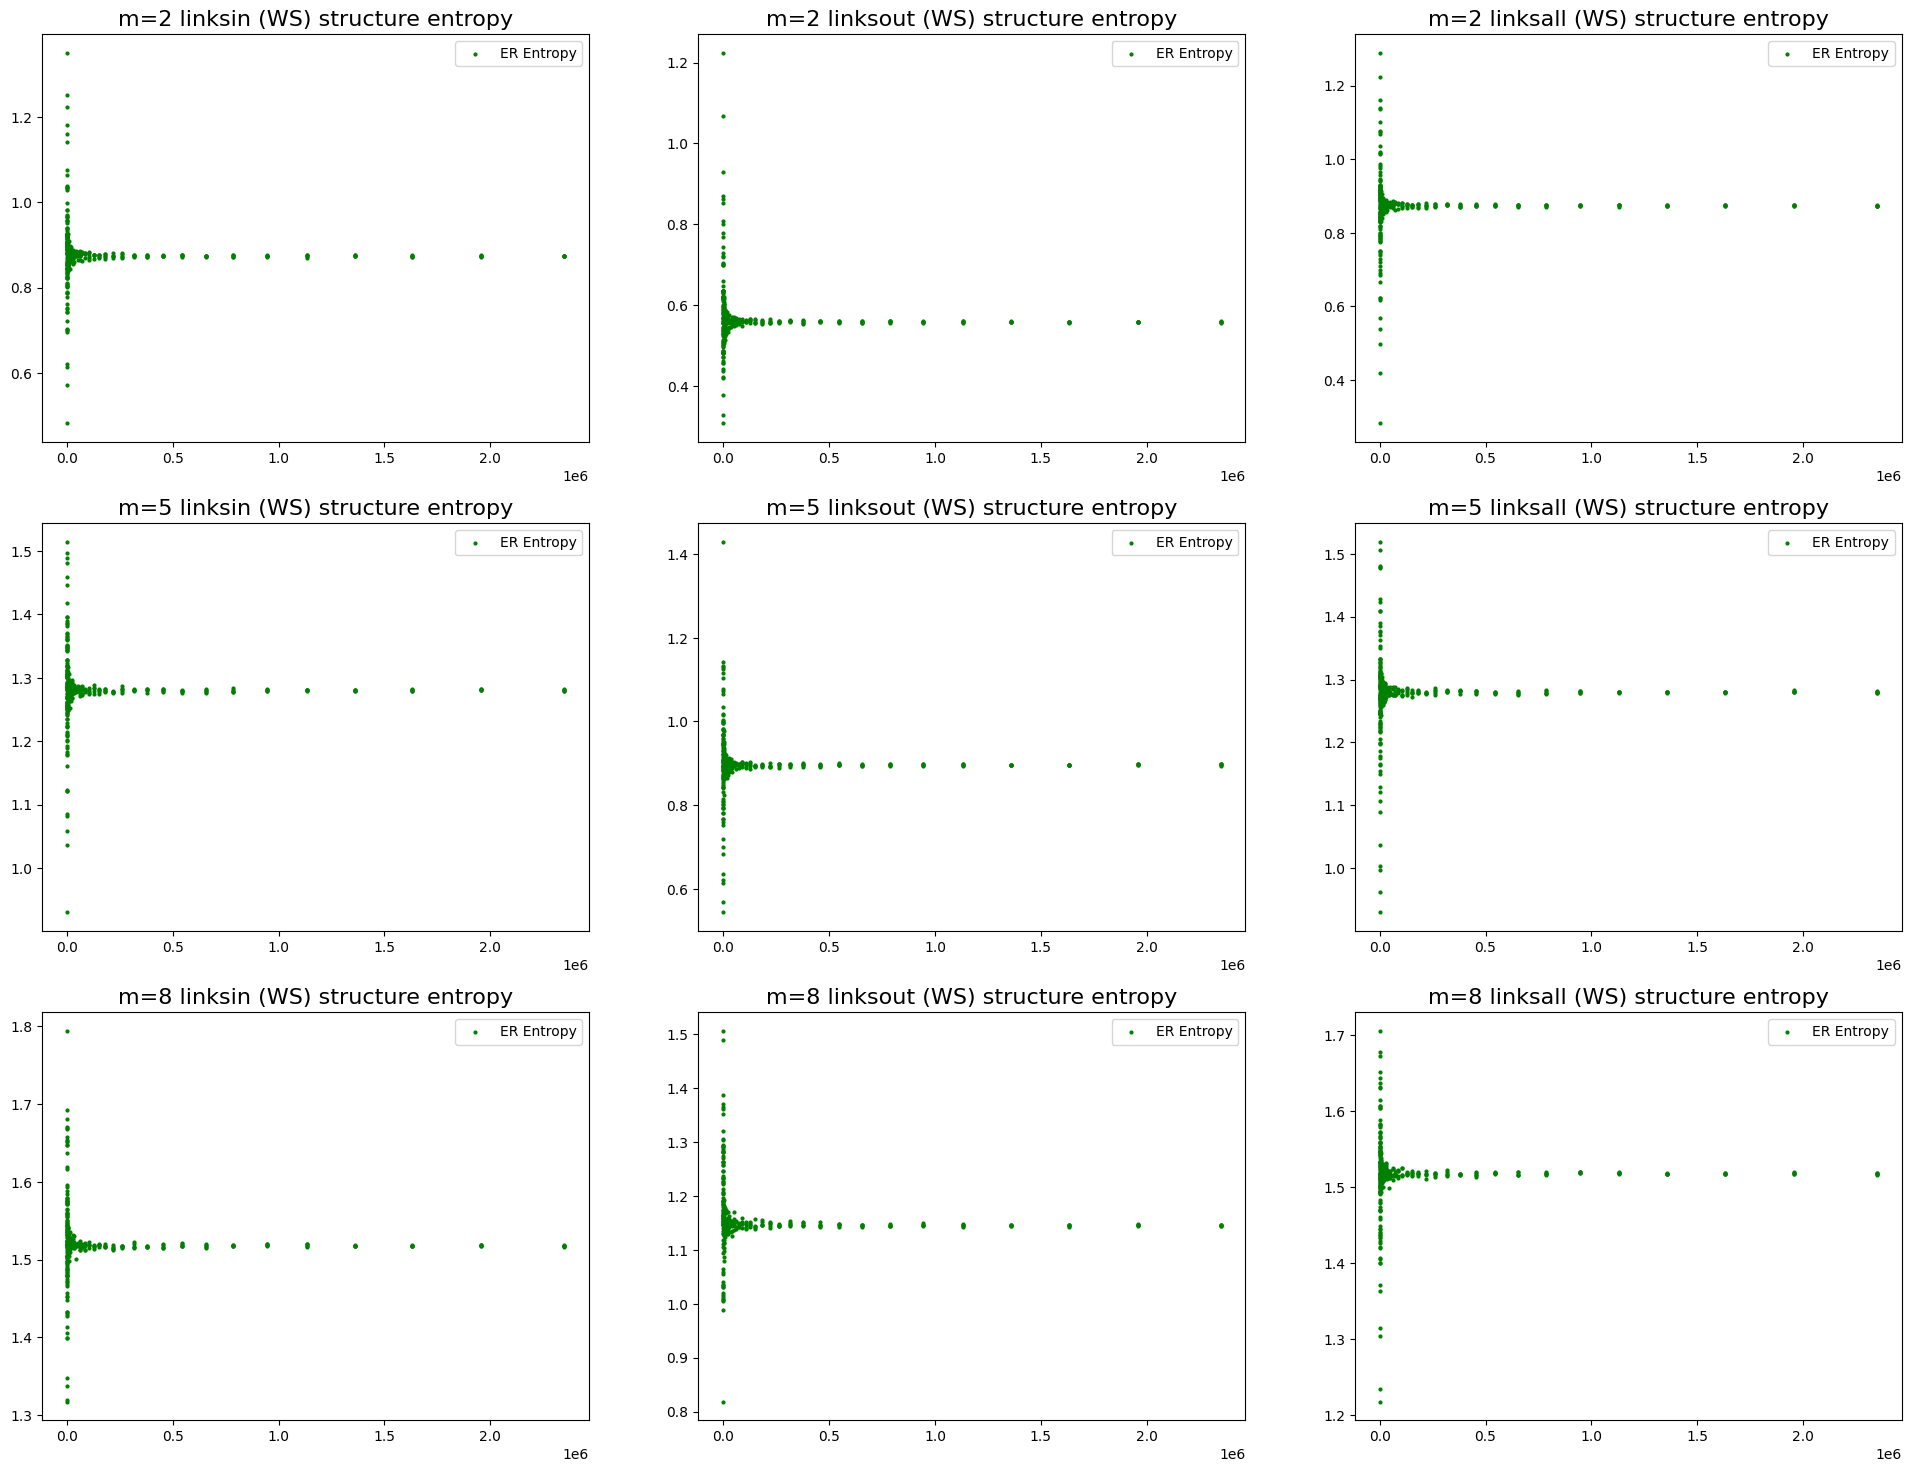

In [162]:

a = [item[0] for item in iterator_ret_data(ret_wsg_p10)]
b = [item[0] for item in iterator_ret_data(ret_wsg_p20)]
c = [item[0] for item in iterator_ret_data(ret_wsg_p30)]

draw_ws_generate_chart(a,b,c,"(WS) structure", "degree")

In [163]:

XLSX_WRITER = pd.ExcelWriter('generate_er_graph_stats.xlsx', engine="xlsxwriter")

In [164]:
# 散点的数量是线程的数量x采样点的数量
und_p10 = [item[1][5] for item in iterator_ret_data(ret_wsg_p10)]
und_p20 = [item[1][5] for item in iterator_ret_data(ret_wsg_p20)]
und_p30 = [item[1][5] for item in iterator_ret_data(ret_wsg_p30)]

df = pd.DataFrame({
    'p10':und_p10,
    'p20':und_p20,
    'p30':und_p30,
}, index=np.tile(sampling_point_list, Thread_Count))

title = "WS Structural Entropy"
df.to_excel(XLSX_WRITER, sheet_name=title, index=True)

workbook = XLSX_WRITER.book
worksheet = XLSX_WRITER.sheets[title]

# 获取数据范围
num_rows, num_cols = df.shape  # 获取行数和列数
start_row = 1  # 数据开始的行（Excel 中 A2 行，0 为标题行）
end_row = start_row + num_rows - 1  # 数据结束行
category_col  = 0  # 月份列（第 1 列，索引从 0 开始）
sales_col = 1  # 销售列（第 2 列）

# 创建折线图
chart = workbook.add_chart({"type": "scatter"})
for col_idx, col_name in enumerate(df.columns, start=1):
    chart.add_series({
        "name":       col_name,  # 图表中的系列名称
        "categories": [title, start_row, category_col, end_row, category_col],  # 分类轴为索引
        "values":     [title, start_row, col_idx, end_row, col_idx],  # 值列
    })
chart.set_title({"name": "WS Undirected Graph: Structural Entropy"})
chart.set_x_axis({"name": "Node"})
chart.set_y_axis({"name": "Entropy",  'num_format': '#,##0'})
chart.set_size({'width': 600, 'height': 400})

# 插入图表
worksheet.insert_chart("B2", chart)

0

In [165]:
# 散点的数量是线程的数量x采样点的数量
und_p10 = [item[0][2] for item in iterator_ret_data(ret_wsg_p10)]
und_p20 = [item[0][2] for item in iterator_ret_data(ret_wsg_p20)]
und_p30 = [item[0][2] for item in iterator_ret_data(ret_wsg_p30)]

df = pd.DataFrame({
    'p10':und_p10,
    'p20':und_p20,
    'p30':und_p30,
}, index=np.tile(sampling_point_list, Thread_Count))

title = "WS Degree Entropy"
df.to_excel(XLSX_WRITER, sheet_name=title, index=True)

workbook = XLSX_WRITER.book
worksheet = XLSX_WRITER.sheets[title]

# 获取数据范围
num_rows, num_cols = df.shape  # 获取行数和列数
start_row = 1  # 数据开始的行（Excel 中 A2 行，0 为标题行）
end_row = start_row + num_rows - 1  # 数据结束行
category_col  = 0  # 月份列（第 1 列，索引从 0 开始）
sales_col = 1  # 销售列（第 2 列）

# 创建折线图
chart = workbook.add_chart({"type": "scatter"})
for col_idx, col_name in enumerate(df.columns, start=1):
    chart.add_series({
        "name":       col_name,  # 图表中的系列名称
        "categories": [title, start_row, category_col, end_row, category_col],  # 分类轴为索引
        "values":     [title, start_row, col_idx, end_row, col_idx],  # 值列
    })
chart.set_title({"name": "WS Undirected Graph: Degree Distribution Entropy"})
chart.set_x_axis({"name": "Node"})
chart.set_y_axis({"name": "Entropy",  'num_format': '#,##0'})
chart.set_size({'width': 600, 'height': 400})

# 插入图表
worksheet.insert_chart("B2", chart)

0

In [166]:
XLSX_WRITER.close()

# 小世界网络重连概率图

In [111]:
sampling_point_list = np.arange(0, 1+0.01, 0.01)

graph_size = 10_000
def process(p):
    G = nx.watts_strogatz_graph(graph_size,10, p)
    # G = nx.newman_watts_strogatz_graph(graph_size,10, p)
    a = handle_entropy_value(G.edges())
    return a

# 采样次数

Thread_Count = 20
pool_xdatas = []

pool_xdatas = np.tile(sampling_point_list,Thread_Count)

with Pool(45) as p:
    ret_wsg_percent = p.map(process, pool_xdatas)

In [112]:
degree_entropy_list = [item[0][2] for item in ret_wsg_percent]
structural_entropy_list = [item[1][5] for item in ret_wsg_percent]

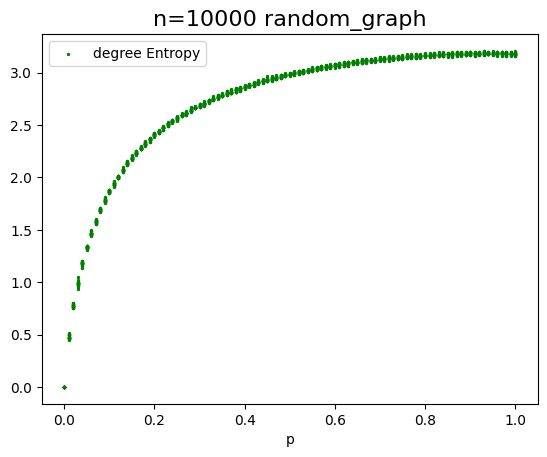

In [113]:
draw_trend(pool_xdatas, degree_entropy_list,"degree")

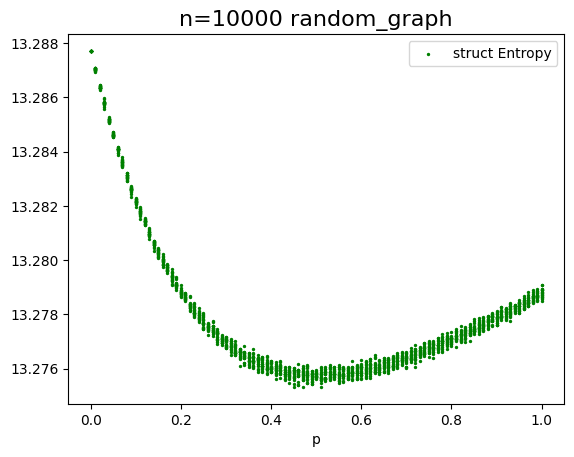

In [114]:
draw_trend(pool_xdatas, structural_entropy_list, "struct")

In [95]:

XLSX_WRITER = pd.ExcelWriter('generate_ws_graph_stats.xlsx', engine="xlsxwriter")

In [96]:
# 散点的数量是线程的数量x采样点的数量
degree_entropy_list = [item[0][2] for item in ret_wsg_percent]
structural_entropy_list = [item[1][5] for item in ret_wsg_percent]

df = pd.DataFrame({
    'degree':degree_entropy_list,
    'structural':structural_entropy_list,
}, index=np.tile(sampling_point_list, Thread_Count))

title = "WS probability"
df.to_excel(XLSX_WRITER, sheet_name=title, index=True)

workbook = XLSX_WRITER.book
worksheet = XLSX_WRITER.sheets[title]

# 获取数据范围
num_rows, num_cols = df.shape  # 获取行数和列数
start_row = 1  # 数据开始的行（Excel 中 A2 行，0 为标题行）
end_row = start_row + num_rows - 1  # 数据结束行
category_col  = 0  # 月份列（第 1 列，索引从 0 开始）
sales_col = 1  # 销售列（第 2 列）

# 创建折线图
chart = workbook.add_chart({"type": "scatter"})
for col_idx, col_name in enumerate(df.columns, start=1):
    chart.add_series({
        "name":       col_name,  # 图表中的系列名称
        "categories": [title, start_row, category_col, end_row, category_col],  # 分类轴为索引
        "values":     [title, start_row, col_idx, end_row, col_idx],  # 值列
    })
chart.set_title({"name": f"WS Undirected Graph {graph_size}: Entropy"})
chart.set_x_axis({"name": "Probility"})
chart.set_y_axis({"name": "Entropy",  'num_format': '#,##0'})
chart.set_size({'width': 600, 'height': 400})

# 插入图表
worksheet.insert_chart("B2", chart)

0

In [97]:
XLSX_WRITER.close()